# SOCAT KPI Plots
This notebook allows you to generate various plots from the SOCAT data for KPI information.

- Begin by running the `Setup and connect to database` cell.
- Select the region of your choice. You will see a map of the region.
- Scroll through the remaining cells to generate plots.

**Prerequisites**
The notebooks `import_socat` and `import_regions` must be run before this notebook.

## Setup and connect to database

In [148]:
import psycopg2
from ipywidgets import interact, interactive_output, fixed, HBox, VBox, Label
import ipywidgets as widgets
from shapely import wkb
import geopandas as gpd
from matplotlib import pyplot as plt
from datetime import datetime
import numpy as np

DB_HOST = 'localhost'
DB_USER = 'postgres'
DB_PASSWORD = 'postgres'
DB_NAME = 'socat_kpi'

conn = psycopg2.connect(database = DB_NAME, 
                        user = DB_USER, 
                        host= DB_HOST,
                        password = DB_PASSWORD)

cur = conn.cursor()

cur.execute('SELECT MIN(year) FROM socat')
for record in cur:
    min_year = record[0]

cur.execute('SELECT MAX(year) FROM socat')
for record in cur:
    max_year = record[0] - 1


# Select Region
Select the region that you're interested in exploring.

In [149]:
def load_region(region_id):
    cur.execute(f'SELECT shape FROM regions WHERE id = {region.value}')
    geom = wkb.loads(cur.fetchone()[0], hex=False)
    gdf = gpd.GeoDataFrame([{'id': region.value, 'geometry': geom}], geometry='geometry', crs='EPSG:4326')
    coastlines = gpd.read_file('shapes/coastline/GSHHS_i_L1.shp')
    
    minx, miny, maxx, maxy = gdf.total_bounds
    padding_x = (maxx - minx) * 0.2  # 20% padding
    padding_y = (maxy - miny) * 0.2
    
    xlim = (minx - padding_x, maxx + padding_x)
    ylim = (miny - padding_y, maxy + padding_y)
    
    
    fig, ax = plt.subplots(figsize=(12, 6))
    coastlines.plot(ax=ax, color='lightgray', linewidth=0.5)
    gdf.plot(ax=ax, color='lightblue', alpha=0.4, edgecolor='black')  # your polygon from PostGIS
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    plt.title(region.label)
    plt.show()

menu_options = []

cur.execute("SELECT id, source, name FROM regions ORDER BY source, name")
for record in cur:
    menu_options.append((f'{record[1]}: {record[2]}', record[0]))

region = widgets.Dropdown(
    options=menu_options,
    description='Region:',
)

interact(load_region, region_id=region);

interactive(children=(Dropdown(description='Region:', options=(('CCAMLR: Division 58.4.1', 19), ('CCAMLR: Divi…

# Make Plots
Each cell below will generate plots for a given metric. Some come with options you can adjust.

## Observation Days Per Year
Shows the number of days with observations in each year.

This can be shown as an absolute value, or relative to the mean of a reference period.

Run the first cell to retrieve the data from the database. Use the second cell to plot it using the interactive controls.

In [150]:
print("Retrieving data...")
cur.execute(f'SELECT s.year, COUNT(DISTINCT(s.month_day)) FROM socat s INNER JOIN regions r ON s.position && r.shape AND ST_Intersects(s.position, r.shape) WHERE r.id = {region.value} GROUP BY s.year ORDER BY s.year')

years = []
counts = []

day_counts = dict()
for y in range(min_year, max_year + 1):
    day_counts[y] = 0

for record in cur:
    day_counts[record[0]] = record[1]

print("Done")

Retrieving data...
Done


In [155]:
def days_per_year(use_reference, reference_start, reference_end, plot_min):

    reference_value = 0
    if use_reference:
        reference_value = np.mean([v for k, v in day_counts.items() if reference_start <= k <= reference_end])
    
    plot_counts = {key: value - reference_value for key, value in day_counts.items()}
    
    plt.bar(plot_counts.keys(), plot_counts.values())
    plt.xlabel('Year')
    
    if use_reference:
        plt.ylabel(f'Number of days relative to {reference_start}-{reference_end} mean')
    else:
        plt.ylabel('Number of Days')
    
    if not use_reference:
        plt.ylim((0, 366))
    else:
        plt.ylim((-365, 365))


    plt.xlim(plot_min - 1, max_year + 1)
    
    plt.title(f'{region.label} \n Days with observations in each year')
    plt.show()


plot_min = next((k for k, v in day_counts.items() if v > 0), None)

relative_checkbox = widgets.Checkbox(value=False, description='Relative to reference period', indent=False)
start_slider = widgets.IntSlider(min=1995, max=datetime.now().year - 1, step=1, value=2015)
end_slider = widgets.IntSlider(min=1995, max=datetime.now().year - 1, step=1, value=2019)

vbox1 = VBox([
    relative_checkbox,
    HBox([Label('Reference period start'), start_slider]),
    HBox([Label('Reference period end'), end_slider]),
])
display(vbox1)

w = interactive_output(days_per_year, {"use_reference": relative_checkbox, "reference_start": start_slider, "reference_end": end_slider, "plot_min": fixed(plot_min)})
display(w)

Output()

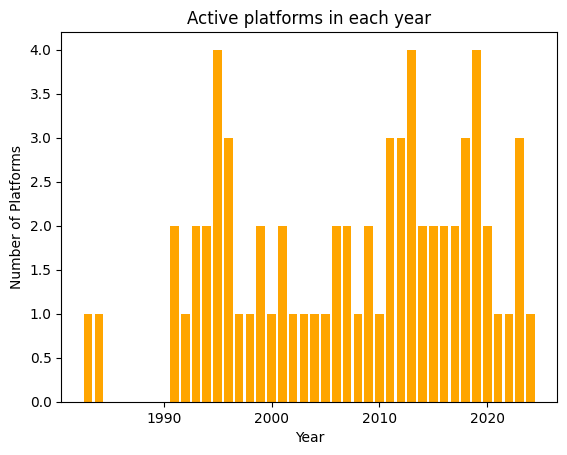

In [153]:
cur.execute(f"SELECT s.year, COUNT(DISTINCT(s.platform_code)) FROM socat s INNER JOIN regions r ON s.position && r.shape AND ST_Intersects(s.position, r.shape) WHERE r.id = {region.value} GROUP BY s.year ORDER BY s.year")

years = []
counts = []

for record in cur:
    years.append(record[0])
    counts.append(record[1])

plt.bar(years, counts, color='orange')
plt.xlabel('Year')
plt.ylabel('Number of Platforms')
plt.title('Active platforms in each year')
plt.show()

## Shutdown

In [154]:
cur.close()
conn.close()